A proof of concept regarding building a CNN from scratch to classify towns / cities from an image.

In [31]:
# Import packages
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image, ImageOps
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
# Desired image size and path
image_size = (224, 224)
dataset_path = "E:/geograph_dataset"

# Create lists for images, city_index, city_name
images = []
labels = []
class_names = []

# Iterate through city folders
for city in sorted(os.listdir(dataset_path)):
    city_path = os.path.join(dataset_path, city)
    if not os.path.isdir(city_path):
        continue
    if city not in class_names:
        class_names.append(city)
    # Iterate through region sub-folders
    for region in os.listdir(city_path):
        region_path = os.path.join(city_path, region)
        if not os.path.isdir(region_path):
            continue
        # Pad and label images based on city
        for image_file in glob.glob(os.path.join(region_path, "*.jpg")):
            img = Image.open(image_file).convert("RGB")
            img = ImageOps.pad(img, image_size, method=Image.BICUBIC, color=(0, 0, 0))
            images.append(np.array(img))
            labels.append(class_names.index(city))

# Normalise images and set lists to arrays
images = np.array(images) / 255.0
labels = np.array(labels)
num_classes = len(class_names)

In [3]:
# Train / temp split (80/20)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=349)

# Temp split into val / test (50/50 of 20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=349)

# One-hot encoded labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [4]:
# Applies random agumentations each epoch
train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# 'Augementation' is just standardisation
val_aug = ImageDataGenerator()

# Generates batches
train_data = train_aug.flow(X_train, y_train_cat, batch_size=32, shuffle=True)
val_data = val_aug.flow(X_val, y_val_cat, batch_size=32)
test_data = val_aug.flow(X_test, y_test_cat, batch_size=32, shuffle=False)

In [13]:
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [14]:
def build_complex_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [32]:
def build_l2_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [29]:
def train_model(model, name):
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6)
    history = model.fit(train_data, validation_data=val_data, epochs=50, callbacks=[early_stop, lr_scheduler], verbose=2)
    model.save(f"{name}.keras")
    return history, model

In [ ]:
input_shape = (224, 224, 3)

cnn = build_cnn(input_shape, num_classes)
complex_cnn = build_complex_cnn(input_shape, num_classes)
l2_cnn = build_l2_cnn(input_shape, num_classes)
resnet = build_resnet(input_shape, num_classes)

history_cnn, model_cnn = train_model(cnn, "cnn_model")
history_complex_cnn, model_complex_cnn = train_model(complex_cnn, "complex_cnn_model")
history_l2_cnn, model_l2_cnn = train_model(l2_cnn, "l2_model")
history_resnet, model_resnet = train_model(resnet, "resnet_model")

In [ ]:
l2_cnn = build_l2_cnn(input_shape, num_classes)

history_l2_cnn, model_l2_cnn = train_model(l2_cnn, "l2_model")

In [ ]:
resnet = build_resnet(input_shape, num_classes)

history_resnet, model_resnet = train_model(resnet, "resnet_model")

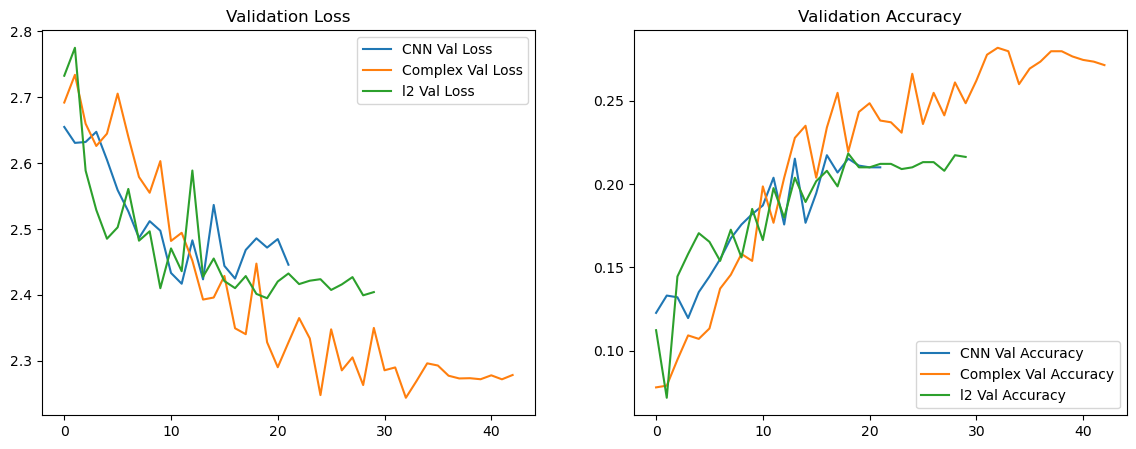

In [38]:
def plot_history(histories, names):
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    for hist, name in zip(histories, names):
        plt.plot(hist.history['val_loss'], label=f'{name} Val Loss')
    plt.title('Validation Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    for hist, name in zip(histories, names):
        plt.plot(hist.history['val_accuracy'], label=f'{name} Val Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.show()

plot_history([history_cnn, history_complex_cnn, history_l2_cnn], ['CNN', 'Complex', 'l2'])

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step

CNN Classification Report:

                       precision    recall  f1-score   support

              ashford       0.18      0.30      0.23        63
           canterbury       0.17      0.01      0.03        72
             dartford       0.00      0.00      0.00        60
                dover       0.21      0.39      0.27        75
            gravesend       0.14      0.16      0.15        64
            maidstone       0.00      0.00      0.00        54
              margate       0.20      0.05      0.08        60
       medway_chatham       0.12      0.45      0.19        56
    medway_gillingham       0.26      0.19      0.22        69
       medway_rainham       0.23      0.10      0.14        52
     medway_rochester       0.10      0.10      0.10        71
royal_tunbridge_wells       0.25      0.71      0.37        75
            sevenoaks       0.27      0.21      0.24        66
        sittingbourne       0.00      0.00     

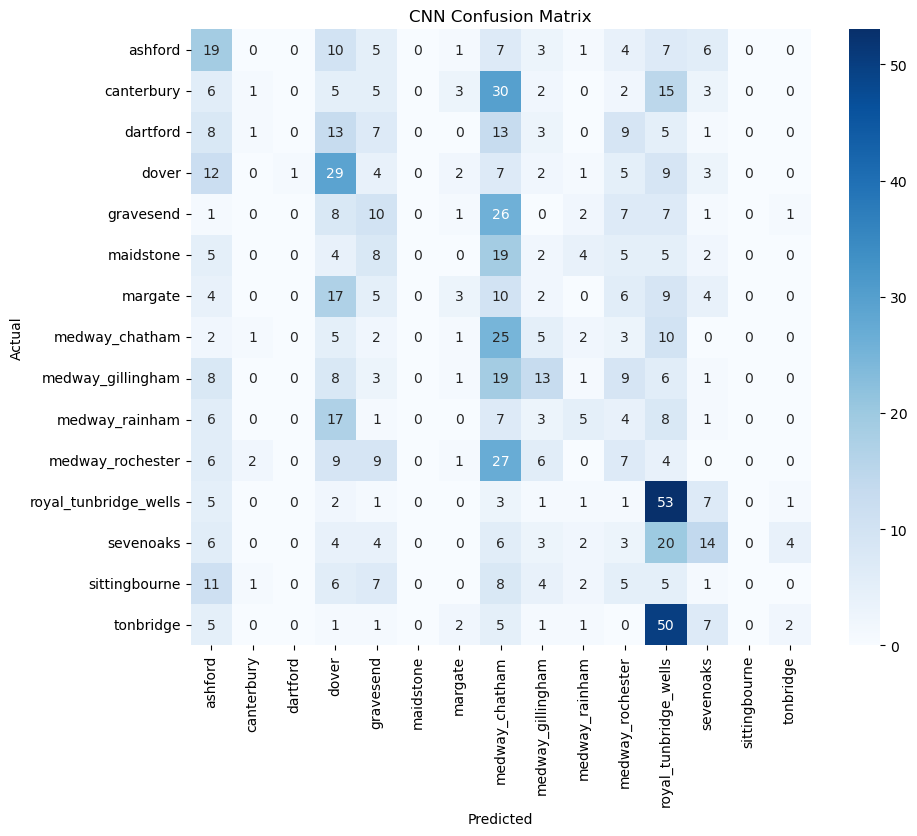

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step

Complex CNN Classification Report:

                       precision    recall  f1-score   support

              ashford       0.31      0.24      0.27        63
           canterbury       0.24      0.28      0.25        72
             dartford       0.15      0.08      0.11        60
                dover       0.29      0.43      0.35        75
            gravesend       0.17      0.45      0.25        64
            maidstone       0.12      0.06      0.08        54
              margate       0.28      0.27      0.27        60
       medway_chatham       0.14      0.11      0.12        56
    medway_gillingham       0.27      0.25      0.26        69
       medway_rainham       0.26      0.17      0.21        52
     medway_rochester       0.17      0.17      0.17        71
royal_tunbridge_wells       0.40      0.52      0.45        75
            sevenoaks       0.31      0.23      0.26        66
        sittingbourne       0.25      0.

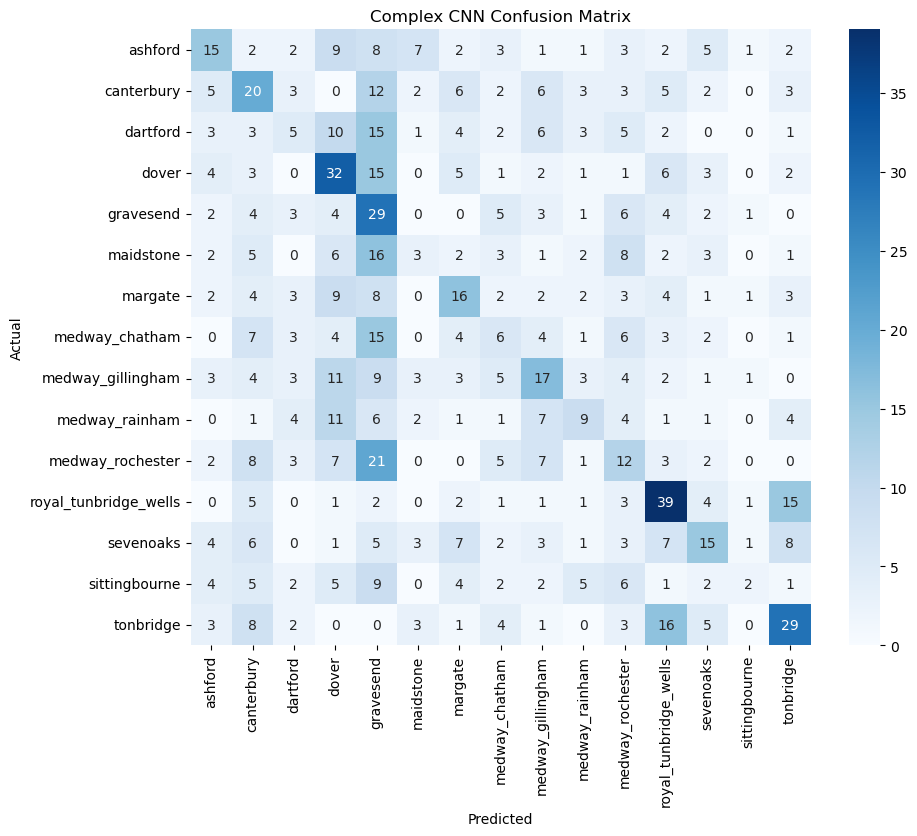

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step

L2 CNN Classification Report:

                       precision    recall  f1-score   support

              ashford       0.24      0.29      0.26        63
           canterbury       0.32      0.14      0.19        72
             dartford       0.00      0.00      0.00        60
                dover       0.20      0.37      0.26        75
            gravesend       0.15      0.44      0.23        64
            maidstone       0.00      0.00      0.00        54
              margate       0.16      0.18      0.17        60
       medway_chatham       0.16      0.09      0.11        56
    medway_gillingham       0.11      0.07      0.09        69
       medway_rainham       0.00      0.00      0.00        52
     medway_rochester       0.09      0.17      0.12        71
royal_tunbridge_wells       0.25      0.64      0.36        75
            sevenoaks       0.17      0.06      0.09        66
        sittingbourne       0.00      0.00   

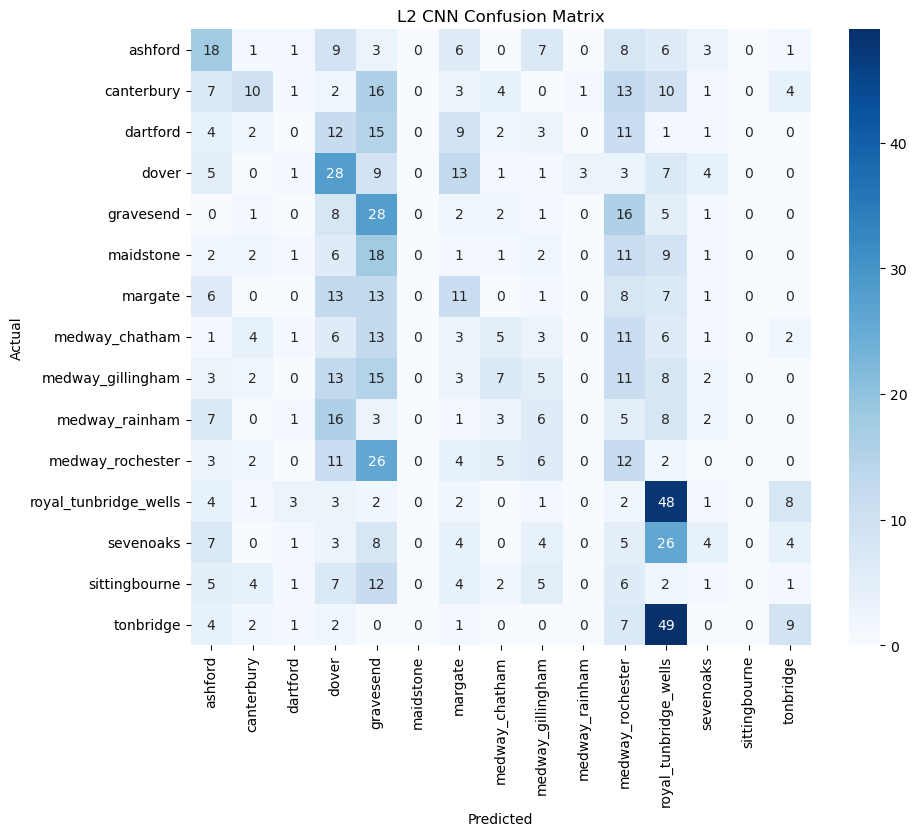

In [39]:
def evaluate_model(model, name):
    # Get model predictions
    preds = model.predict(test_data)
    
    # Get predicted class labels
    pred_classes = np.argmax(preds, axis=1)
    
    # Convert one-hot encoded true labels to class labels
    true_classes = np.argmax(y_test_cat, axis=1)  # Convert one-hot encoding to class labels

    print(f"\n{name} Classification Report:\n")
    # Use zero_division=0 to handle cases where precision/recall is undefined
    print(classification_report(true_classes, pred_classes, target_names=class_names, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(true_classes, pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(model_cnn, "CNN")
evaluate_model(model_complex_cnn, "Complex CNN")
evaluate_model(model_l2_cnn, "L2 CNN")

Adding the l2 regulariser did not appear to improve the CNN, it performed about as well as the CNN without dropout. Just dropout had the highest accuracy. This would suggest just adding a dense layer with droput might be best for when CNN using transfer learning is built. An accuracy of 26% is 3.9x better than the 6.7% accuracy of random guessing showing that the CNN has learnt features in the images but still has a lot of room for improvement.